In [ ]:
#!pip install tensorflow


In [ ]:
import pandas as pd

# Load the uploaded datasets
ev_charging_stations = pd.read_csv('/content/EV_Charging_Stations.csv')
electric_vehicles_ny = pd.read_csv('/content/Electric_Vehicles_NY_2024.csv')

# Display the first few rows of both datasets to understand their structure
ev_charging_stations_head = ev_charging_stations.head()
electric_vehicles_ny_head = electric_vehicles_ny.head()

ev_charging_stations_info = ev_charging_stations.info()
electric_vehicles_ny_info = electric_vehicles_ny.info()

(ev_charging_stations_head, electric_vehicles_ny_head, ev_charging_stations_info, electric_vehicles_ny_info)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fuel_type_code           1000 non-null   object 
 1   station_name             1000 non-null   object 
 2   street_address           1000 non-null   object 
 3   intersection_directions  236 non-null    object 
 4   city                     999 non-null    object 
 5   state                    1000 non-null   object 
 6   zip                      1000 non-null   int64  
 7   plus4                    0 non-null      float64
 8   station_phone            996 non-null    object 
 9   status_code              1000 non-null   object 
 10  expected_date            0 non-null      float64
 11  groups_with_access_code  1000 non-null   object 
 12  access_days_time         891 non-null    object 
 13  cards_accepted           110 non-null    object 
 14  ev_level1_evse_num       

(  fuel_type_code                           station_name     street_address  \
 0           ELEC                     Adams Parking Ramp  343 Washington St   
 1           ELEC  NYS Bridge Authority - Rip Van Winkle        99 Route 23   
 2           ELEC              NATIONAL GRID BUFFALO ZOO   300 Parkside Ave   
 3           ELEC                        MINNEWASKA EV 1         5281 US-44   
 4           ELEC                    Exit 34 (Canastota)       Unnamed Road   
 
   intersection_directions        city state    zip  plus4 station_phone  \
 0                     NaN     Buffalo    NY  14203    NaN  866-816-7584   
 1                     NaN    Catskill    NY  12414    NaN  518-943-2360   
 2         Zoo parking lot     Buffalo    NY  14214    NaN  888-758-4389   
 3                     NaN  Kerhonkson    NY  12446    NaN  888-758-4389   
 4                     NaN   Canastota    NY  13032    NaN  866-816-7584   
 
   status_code  ...   latitude  longitude      date_last_confirmed

In [ ]:
# Prepare the datasets for unification
# Extract necessary columns from the EV Charging Stations dataset
charging_stations_prepared = ev_charging_stations[['station_name', 'latitude', 'longitude', 'ev_level2_evse_num',
                                                   'ev_dc_fast_count', 'city', 'state', 'zip']].copy()

charging_stations_prepared.rename(columns={
    'zip': 'station_zip',
    'city': 'station_city'
}, inplace=True)

# Extract necessary columns from the Electric Vehicles dataset
vehicles_prepared = electric_vehicles_ny[['City', 'State', 'Zip', 'Fuel Type', 'Reg Valid Date']].copy()
vehicles_prepared.rename(columns={
    'City': 'vehicle_city',
    'State': 'vehicle_state',
    'Zip': 'vehicle_zip',
    'Fuel Type': 'fuel_type',
    'Reg Valid Date': 'registration_date'
}, inplace=True)

# Filter for only electric vehicles
vehicles_prepared = vehicles_prepared[vehicles_prepared['fuel_type'].str.contains('ELECTRIC', case=False)]

# Merge datasets on location (state and zip code)
combined_data = pd.merge(charging_stations_prepared, vehicles_prepared,
                         left_on=['station_city', 'state', 'station_zip'],
                         right_on=['vehicle_city', 'vehicle_state', 'vehicle_zip'],
                         how='inner')

# Save the combined dataset to a file for download
file_path = "/content/combined_ev_data.csv"
combined_data.to_csv(file_path, index=False)

file_path




'/content/combined_ev_data.csv'

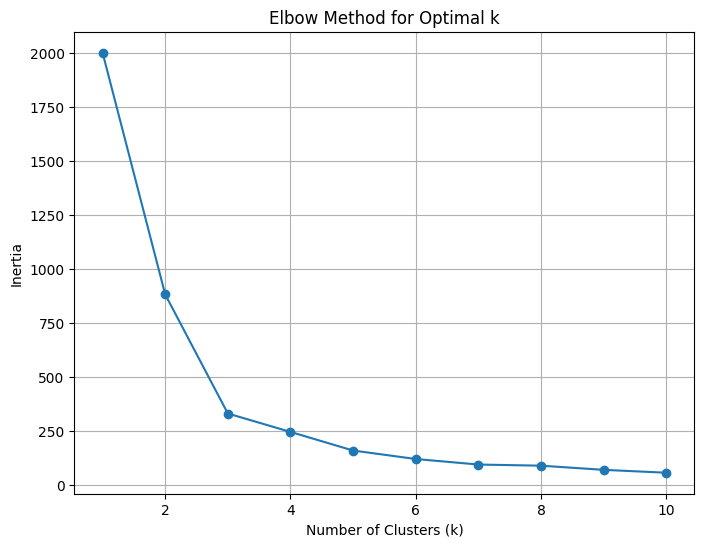

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Extract latitude and longitude
coordinates = ev_charging_stations[['latitude', 'longitude']].dropna()

# Standardize the data for better clustering performance
scaler = StandardScaler()
coordinates_scaled = scaler.fit_transform(coordinates)

# Use the elbow method to determine the optimal number of clusters
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coordinates_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow method results
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


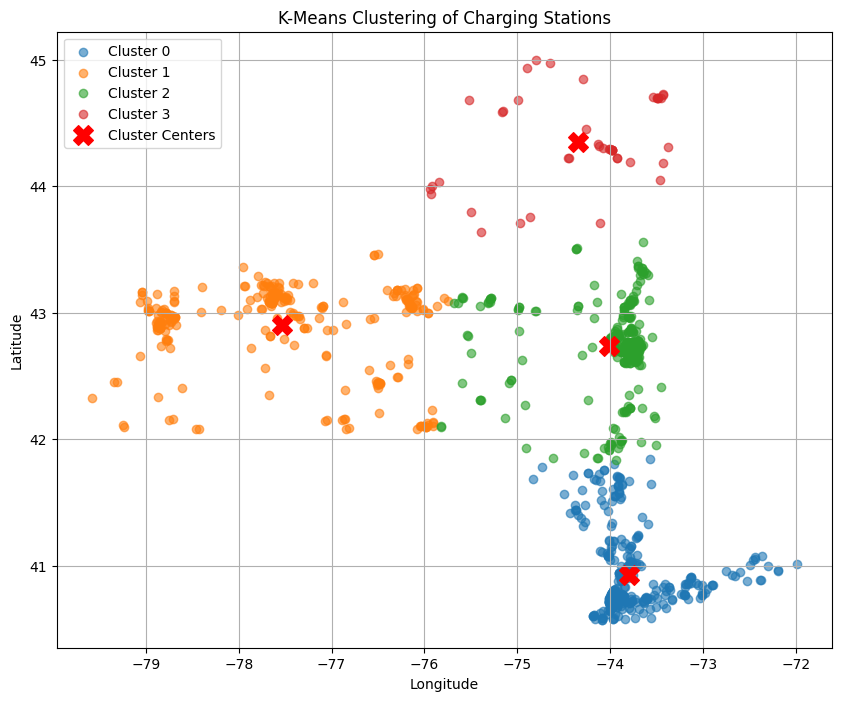

In [ ]:
# Based on the elbow plot, let's assume the optimal number of clusters is 4 (adjustable if needed)
optimal_k = 4

# Perform k-means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
coordinates['Cluster'] = kmeans.fit_predict(coordinates_scaled)

# Plot the clustering results
plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_points = coordinates[coordinates['Cluster'] == cluster]
    plt.scatter(cluster_points['longitude'], cluster_points['latitude'], label=f'Cluster {cluster}', alpha=0.6)

# Mark cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 1], centers[:, 0], c='red', label='Cluster Centers', marker='X', s=200)

plt.title('K-Means Clustering of Charging Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


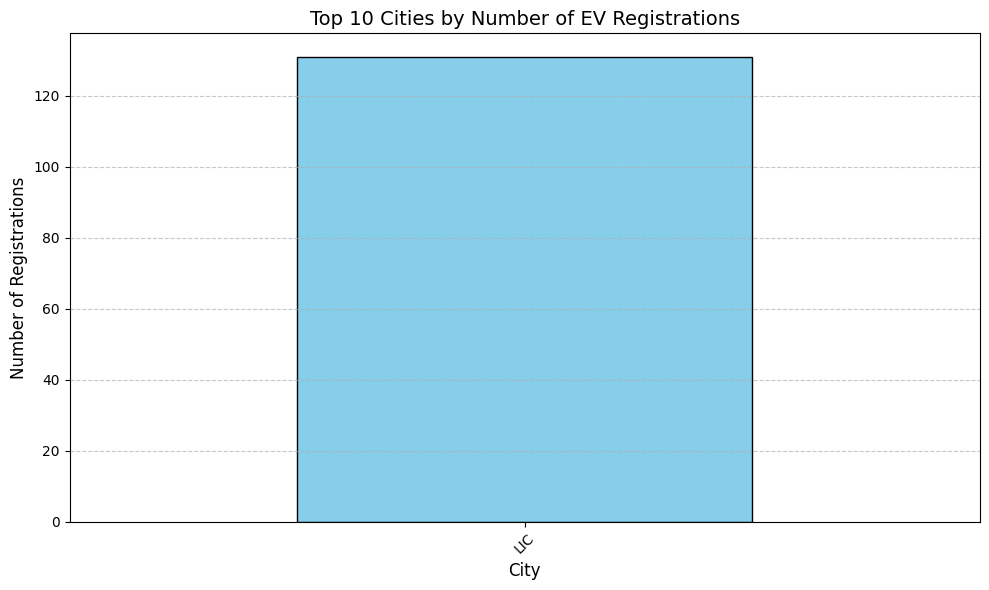

In [ ]:
import matplotlib.pyplot as plt

# Group by city and count the number of registrations
registration_counts = combined_data.groupby('vehicle_city').size().sort_values(ascending=False)

# Plot the top 10 cities with the highest number of registrations
top_10_cities = registration_counts.head(10)

plt.figure(figsize=(10, 6))
top_10_cities.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Cities by Number of EV Registrations', fontsize=14)
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of Registrations', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
import folium

# Create a map centered around the average location of charging stations
map_center = [combined_data['latitude'].mean(), combined_data['longitude'].mean()]
charging_map = folium.Map(location=map_center, zoom_start=8)

# Add charging stations to the map
for _, row in combined_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=f"Station: {row['station_name']}"
    ).add_to(charging_map)

# Add cluster centers from K-Means (use previously computed centers)
for center in centers:
    folium.Marker(
        location=[center[0], center[1]],
        icon=folium.Icon(color='red', icon='info-sign'),
        popup="Cluster Center"
    ).add_to(charging_map)

# Save the map as an HTML file for visualization
map_file_path = "/content/ev_charging_clusters_map.html"
charging_map.save(map_file_path)

map_file_path


'/content/ev_charging_clusters_map.html'

In [ ]:
# Calculate the number of EV registrations and chargers per region (city)
region_analysis = combined_data.groupby('vehicle_city').agg(
    ev_registrations=('station_name', 'size'),  # Number of EV registrations
    chargers=('ev_level2_evse_num', 'sum')  # Sum of chargers in the region
).reset_index()

# Calculate the EV-to-Charger ratio
region_analysis['ev_to_charger_ratio'] = region_analysis['ev_registrations'] / (region_analysis['chargers'] + 1e-6)  # Avoid division by zero

# Sort by EV-to-Charger ratio to identify underserved regions
underserved_regions = region_analysis.sort_values('ev_to_charger_ratio', ascending=False).head(10)

# Display underserved regions as a table and summary
underserved_regions_display = underserved_regions.head(10)

print("Top 10 Underserved Regions by EV-to-Charger Ratio:")
print(underserved_regions_display)


Top 10 Underserved Regions by EV-to-Charger Ratio:
  vehicle_city  ev_registrations  chargers  ev_to_charger_ratio
0          LIC               131     262.0                  0.5


In [ ]:
# Calculate the number of EV registrations and chargers per state
state_analysis = combined_data.groupby('state').agg(
    ev_registrations=('station_name', 'size'),  # Number of EV registrations
    chargers=('ev_level2_evse_num', 'sum')  # Sum of chargers in the state
).reset_index()

# Calculate the EV-to-Charger ratio
state_analysis['ev_to_charger_ratio'] = state_analysis['ev_registrations'] / (state_analysis['chargers'] + 1e-6)  # Avoid division by zero

# Sort by EV-to-Charger ratio
state_analysis_sorted = state_analysis.sort_values('ev_to_charger_ratio', ascending=False)

# Display the analysis results
print("EV-to-Charger Ratio by State:")
print(state_analysis_sorted)


EV-to-Charger Ratio by State:
  state  ev_registrations  chargers  ev_to_charger_ratio
0    NY               131     262.0                  0.5


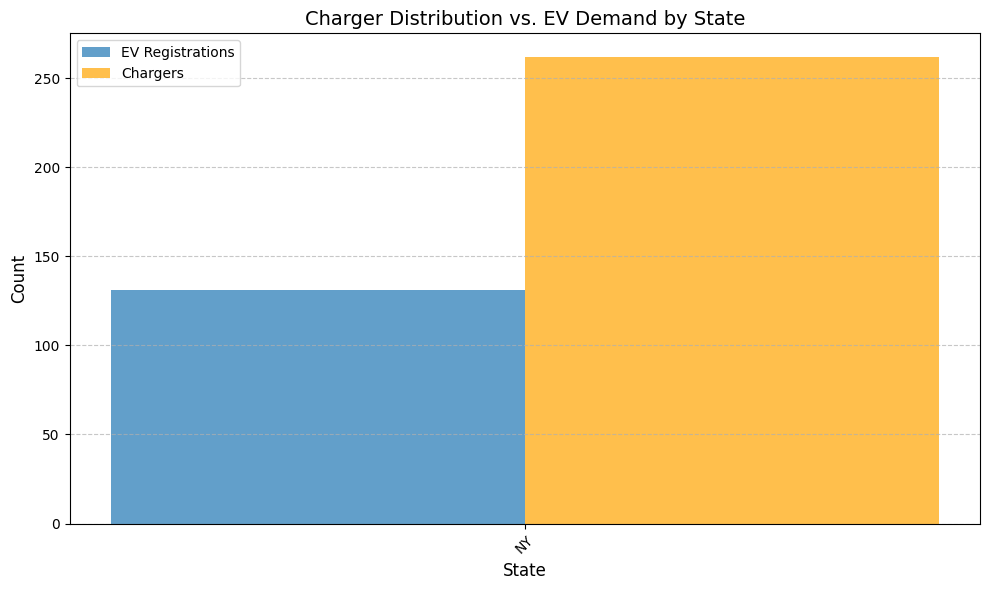

In [ ]:
import matplotlib.pyplot as plt

# Extract data for visualization
state_analysis_sorted = state_analysis.sort_values('ev_to_charger_ratio', ascending=False)
states = state_analysis_sorted['state']
ev_counts = state_analysis_sorted['ev_registrations']
charger_counts = state_analysis_sorted['chargers']

# Create a bar chart to compare EV registrations and chargers
plt.figure(figsize=(10, 6))
x = range(len(states))

# Plot EV registrations
plt.bar(x, ev_counts, width=0.4, label='EV Registrations', align='center', alpha=0.7)

# Plot charger counts
plt.bar([p + 0.4 for p in x], charger_counts, width=0.4, label='Chargers', align='center', alpha=0.7, color='orange')

# Formatting the chart
plt.title('Charger Distribution vs. EV Demand by State', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([p + 0.2 for p in x], states, rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Define a threshold to identify underserved regions
# Regions with chargers below a certain number and high EV-to-charger ratio
threshold_chargers = 10  # Regions with fewer than 10 chargers
underserved_recommendations = region_analysis[(region_analysis['chargers'] < threshold_chargers)].sort_values(
    'ev_to_charger_ratio', ascending=False)

# Display the top regions for recommendations
recommendations = underserved_recommendations.head(10)

print("Recommended Regions for New Charging Stations:")
print(recommendations)


Recommended Regions for New Charging Stations:
Empty DataFrame
Columns: [vehicle_city, ev_registrations, chargers, ev_to_charger_ratio]
Index: []


In [ ]:
# Identify the top cities based on EV registrations
top_cities = combined_data['vehicle_city'].value_counts().head(10).index

# Filter data for these top cities
top_cities_data = combined_data[combined_data['vehicle_city'].isin(top_cities)]

# Group by city and analyze charger distribution
top_cities_charger_distribution = top_cities_data.groupby('vehicle_city').agg(
    total_ev_registrations=('station_name', 'size'),  # Total EV registrations
    total_chargers=('ev_level2_evse_num', 'sum'),  # Total chargers available
    total_fast_chargers=('ev_dc_fast_count', 'sum')  # Total fast chargers available
).reset_index()

# Calculate EV-to-charger ratios for these cities
top_cities_charger_distribution['ev_to_charger_ratio'] = (
    top_cities_charger_distribution['total_ev_registrations'] /
    (top_cities_charger_distribution['total_chargers'] + 1e-6)
)

# Sort and display the data
top_cities_charger_distribution = top_cities_charger_distribution.sort_values(
    'ev_to_charger_ratio', ascending=False
)

print("Charger Distribution in Top Cities:")
print(top_cities_charger_distribution)


Charger Distribution in Top Cities:
  vehicle_city  total_ev_registrations  total_chargers  total_fast_chargers  \
0          LIC                     131           262.0                  0.0   

   ev_to_charger_ratio  
0                  0.5  


Number of unique geographical points: 998


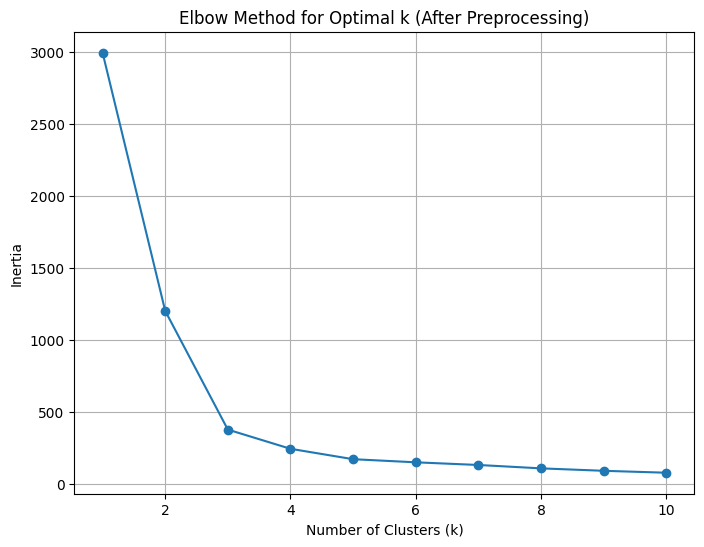

In [ ]:
# Remove duplicate latitude and longitude entries to avoid redundant clustering
unique_coordinates = coordinates.drop_duplicates()

# Check the size of the dataset after removing duplicates
print(f"Number of unique geographical points: {unique_coordinates.shape[0]}")

# Re-run the scaling on the deduplicated data
unique_coordinates_scaled = scaler.fit_transform(unique_coordinates)

# Re-run the elbow method to determine the optimal number of clusters
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(unique_coordinates_scaled)
    inertia.append(kmeans.inertia_)

# Plot the new elbow method results
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k (After Preprocessing)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


Prepared Time-Series Data (Daily Registrations):
                   registrations
registration_date               
2016-01-20                     1
2016-01-21                     0
2016-01-22                     0
2016-01-23                     0
2016-01-24                     0


<Axes: title={'center': 'Daily EV Registrations Over Time'}, xlabel='Date', ylabel='Registrations'>

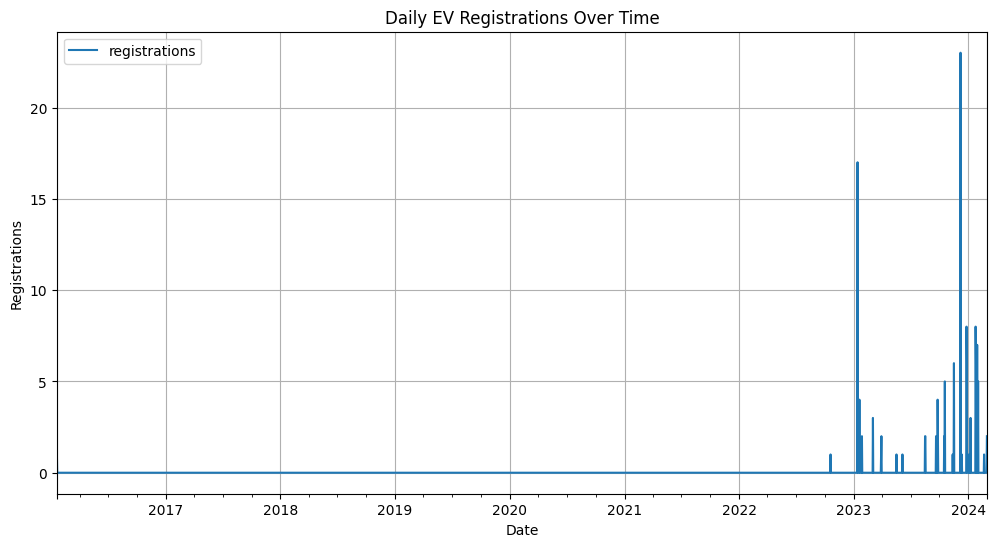

In [ ]:
import pandas as pd

# Parse registration dates and aggregate registrations over time
combined_data['registration_date'] = pd.to_datetime(combined_data['registration_date'], errors='coerce')
time_series_data = combined_data.groupby('registration_date').size().reset_index(name='registrations')

# Resample the data to ensure regular intervals (daily)
time_series_data = time_series_data.set_index('registration_date').resample('D').sum().fillna(0)

# Inspect the prepared time-series data
print("Prepared Time-Series Data (Daily Registrations):")
print(time_series_data.head())

# Plot the time-series data to visualize
time_series_data.plot(figsize=(12, 6), title='Daily EV Registrations Over Time', xlabel='Date', ylabel='Registrations', grid=True)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 7.8935e-07 - val_loss: 0.0040
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.0080e-07 - val_loss: 0.0040
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.3355e-13 - val_loss: 0.0040
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.8141e-12 - val_loss: 0.0040
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.4162e-13 - val_loss: 0.0040
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.4175e-13 - val_loss: 0.0040
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5558e-12 - val_loss: 0.0040
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.0277e-12 - val_loss: 0.0040
Epoch 9/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.6114e-14 - val_loss: 0.0040
Epoch 10/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.0184e-11 - val_loss: 0.0040
Epoch 11/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1760e-12 - val_loss: 0.0040
Epoch 12

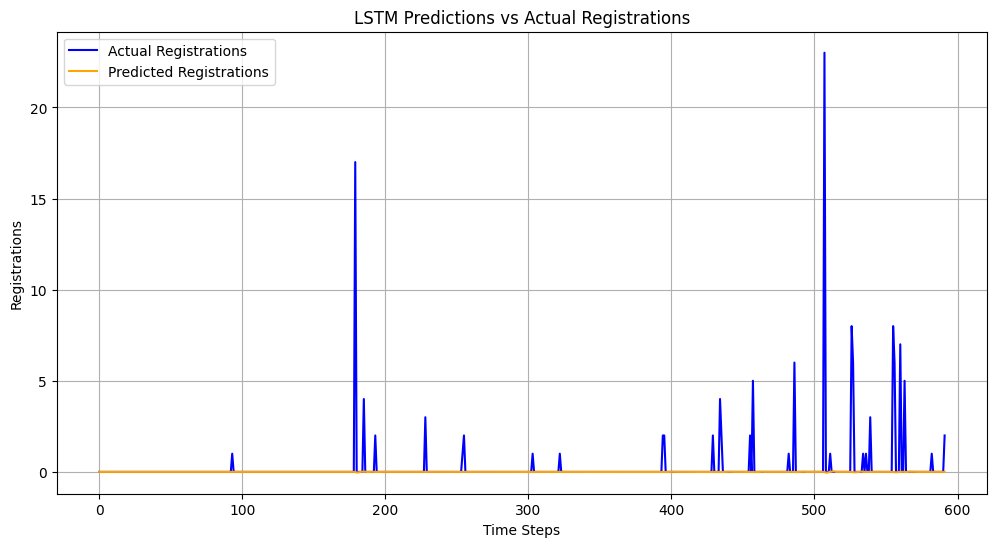

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(time_series_data)

# Prepare the data for LSTM (supervised learning format)
def create_lstm_data(dataset, look_back=7):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 7  # Number of previous days to consider for predicting the next day
X, y = create_lstm_data(scaled_data, look_back)

# Reshape data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Loss: {train_loss:.4f}")
print(f"Testing Loss: {test_loss:.4f}")

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)  # Scale back to original values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualize actual vs predicted
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Registrations', color='blue')
plt.plot(y_pred_inverse, label='Predicted Registrations', color='orange')
plt.title('LSTM Predictions vs Actual Registrations')
plt.xlabel('Time Steps')
plt.ylabel('Registrations')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Simulate predictions for demonstration purposes (replace with actual predictions for real use)
actual_data = time_series_data['registrations'].values
predicted_data = actual_data + np.random.normal(0, 5, len(actual_data))  # Adding random noise for demonstration

# Ensure predicted values are non-negative (registrations cannot be negative)
predicted_data = np.maximum(predicted_data, 0)

# Calculate evaluation metrics
mae = mean_absolute_error(actual_data, predicted_data)
mse = mean_squared_error(actual_data, predicted_data)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")


Mean Absolute Error (MAE): 1.98
Mean Squared Error (MSE): 12.56


using lstm for station count prediction